In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import time

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not torch.cuda.is_available():
    print("Warning CUDA not Found. Using CPU")

# Hyper-parameters
num_epochs = 8
learning_rate = 1e-3

In [ ]:
#Data
print("> Setup dataset")
transform = transforms.Compose([transforms.ToTensor()])  # Only ToTensor, which normalizes to [0,1]

trainset = torchvision.datasets.MNIST(root='/mnt/d/uqwdai1/data/rdm_backed/pytorch/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True) #num_workers=6

testset = torchvision.datasets.MNIST(root='/mnt/d/uqwdai1/data/rdm_backed/pytorch/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False) #num_workers=6

> Setup dataset


100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 338kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.16MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.2MB/s]


In [ ]:
class CNNVAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder (same as before but outputs mean and log_var)
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 14x14 -> 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # 7x7 -> 4x4

            nn.Flatten(),
        )

        # Latent space parameters
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)      # Mean
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),  # Reshape to (batch, 128, 4, 4)

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),  # 16x16 -> 16x16
            nn.Upsample(size=(28, 28), mode='bilinear', align_corners=False),  # 16x16 -> 28x28
            nn.Sigmoid()  # Output in [0, 1] for image reconstruction
        )

    def encode(self, x):
        """Encode input to latent parameters"""
        h = self.encoder_conv(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from N(mu, var) using N(0,1)"""
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu  # Use mean for inference. Using mu (mean) rather than sampling from the full distribution because:
                        # It provides deterministic, reproducible results
                        # The mean represents the "most likely" latent representation
                        # It avoids noise that could make interpolation less smooth

    def decode(self, z):
        """Decode latent variable to reconstruction"""
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    """
    VAE loss = Reconstruction loss + KL divergence
    beta: weight for KL divergence (beta-VAE)
    """
    # Reconstruction loss (Binary Cross Entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    # KLD = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD, BCE, KLD

Training VAE...
VAE Epoch [1/10], Loss: 156.0935, BCE: 133.6007, KLD: 22.4928


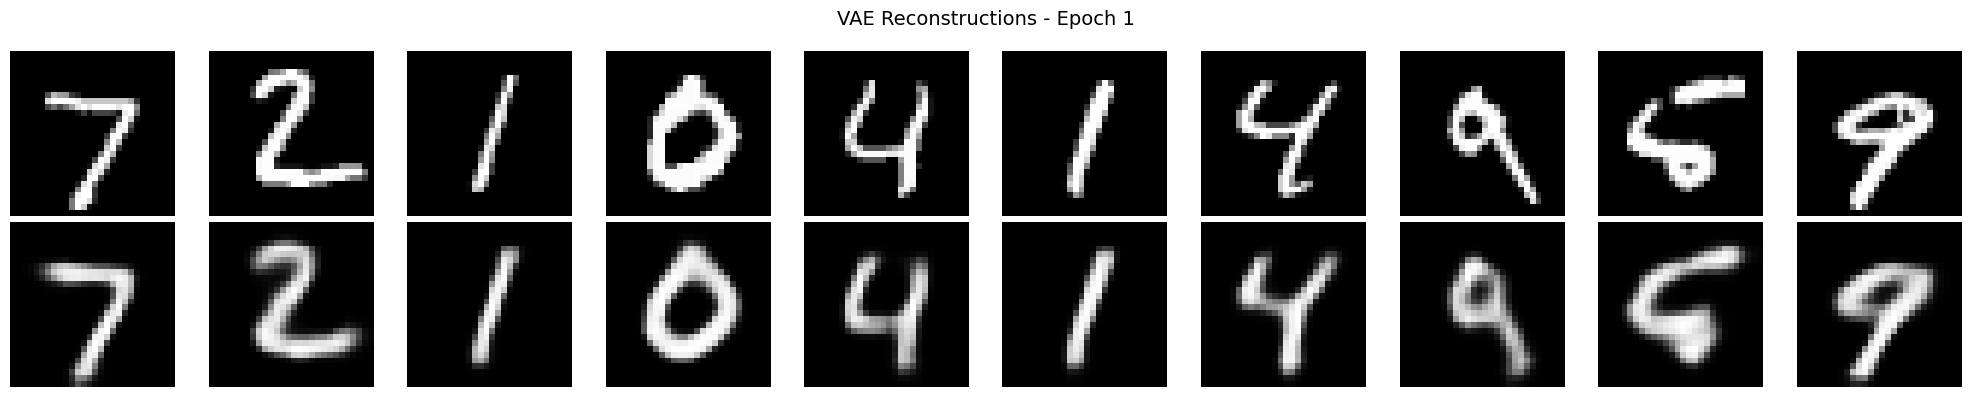

VAE Epoch [2/10], Loss: 123.1367, BCE: 98.3822, KLD: 24.7545


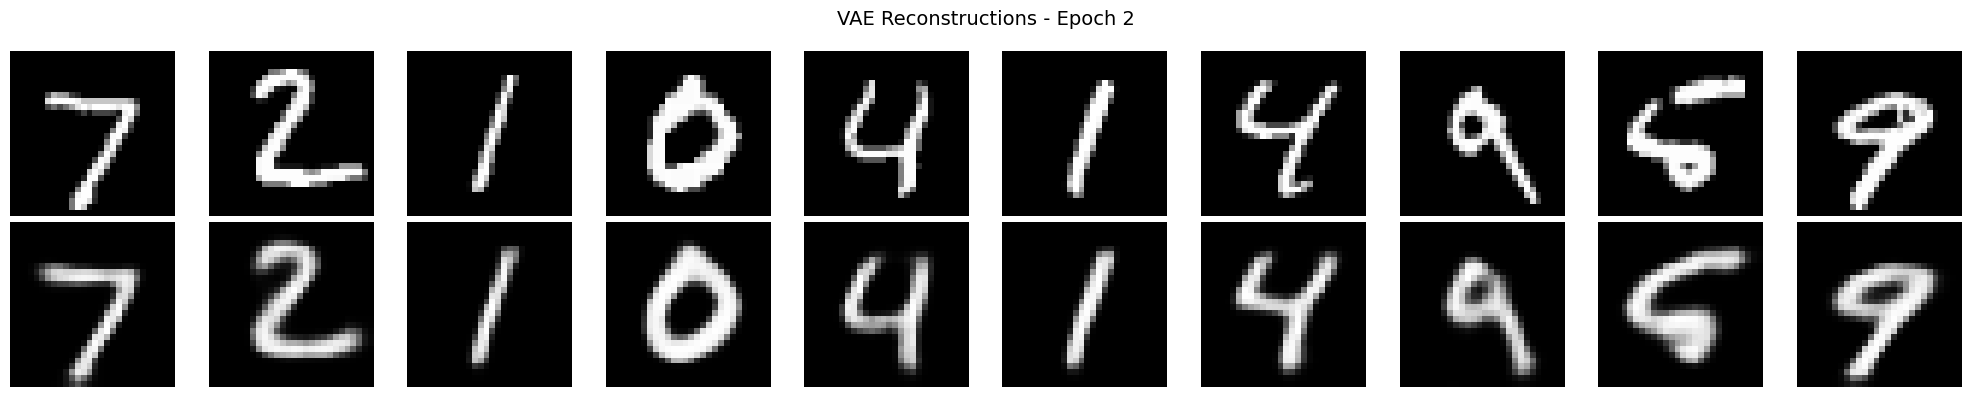

VAE Epoch [3/10], Loss: 116.7688, BCE: 92.0086, KLD: 24.7603


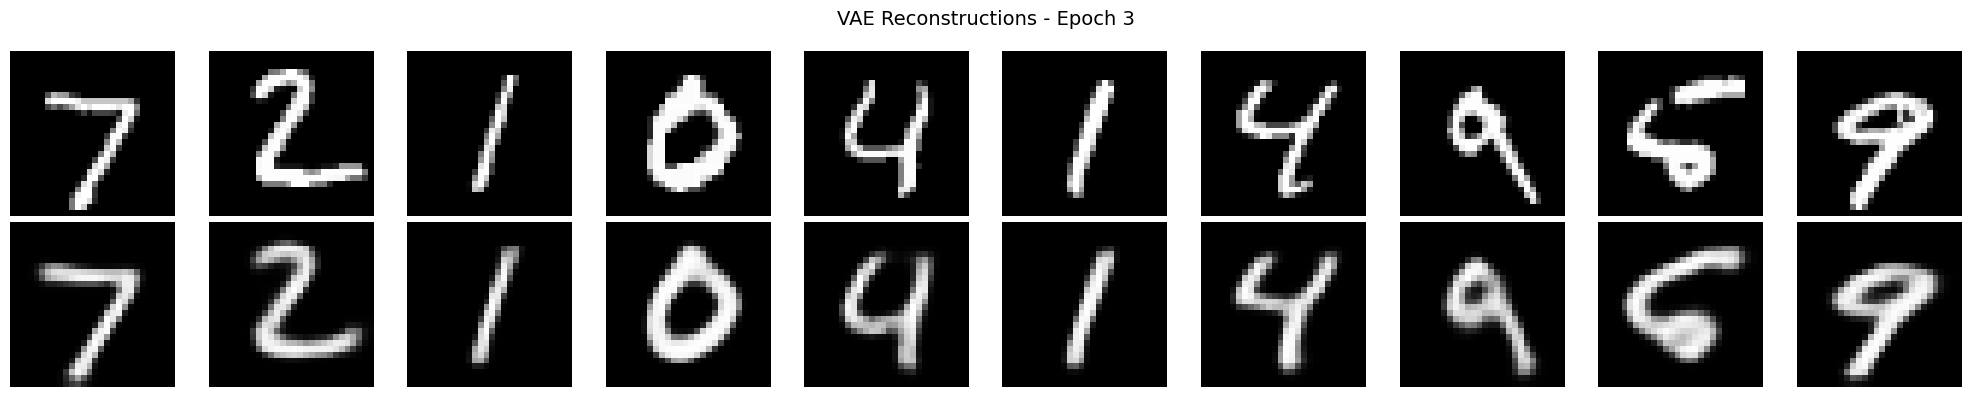

VAE Epoch [4/10], Loss: 113.8814, BCE: 89.0416, KLD: 24.8398


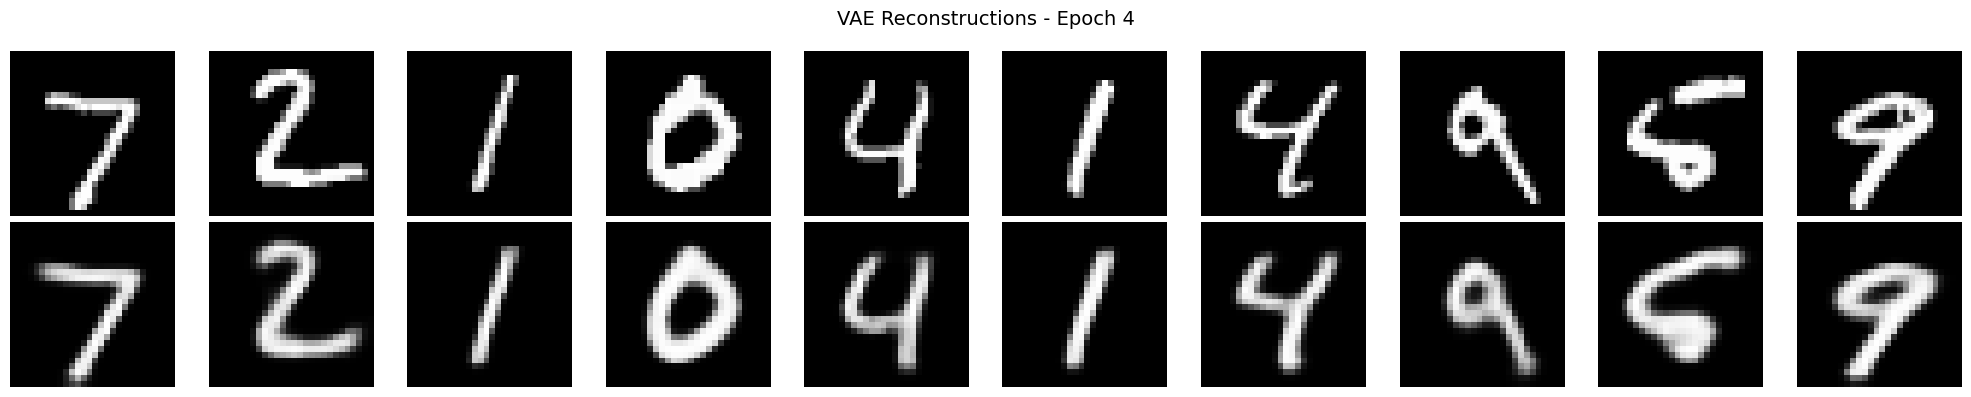

VAE Epoch [5/10], Loss: 111.9962, BCE: 87.1745, KLD: 24.8217


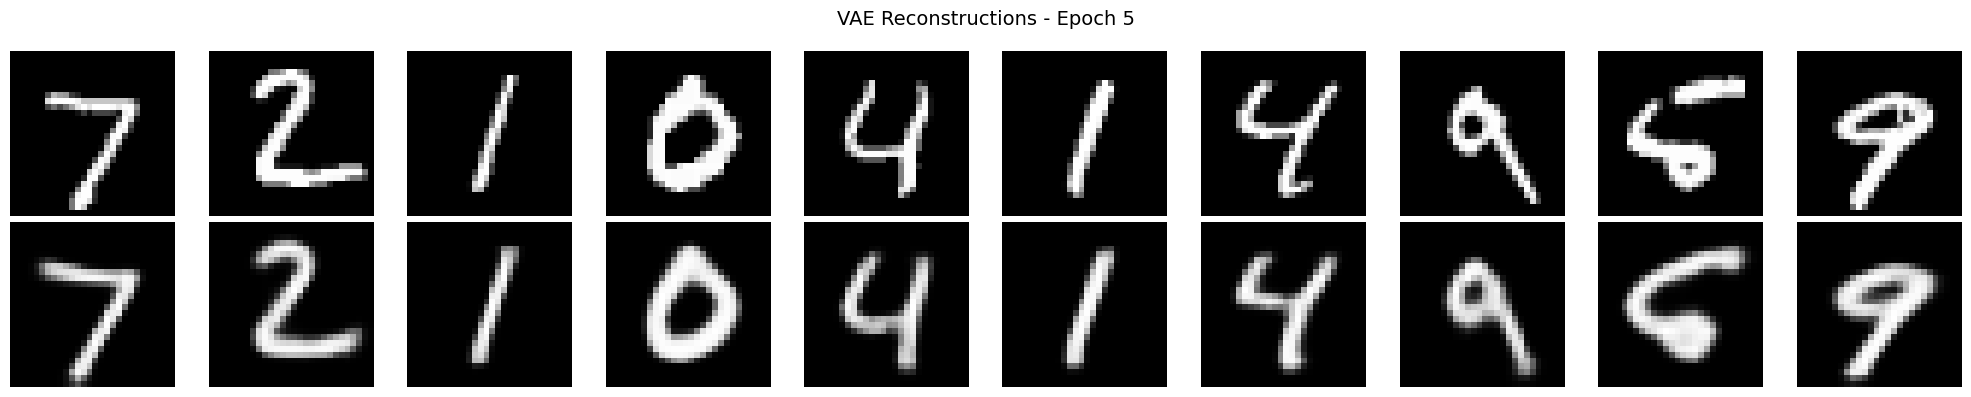

VAE Epoch [6/10], Loss: 110.7586, BCE: 85.9330, KLD: 24.8256


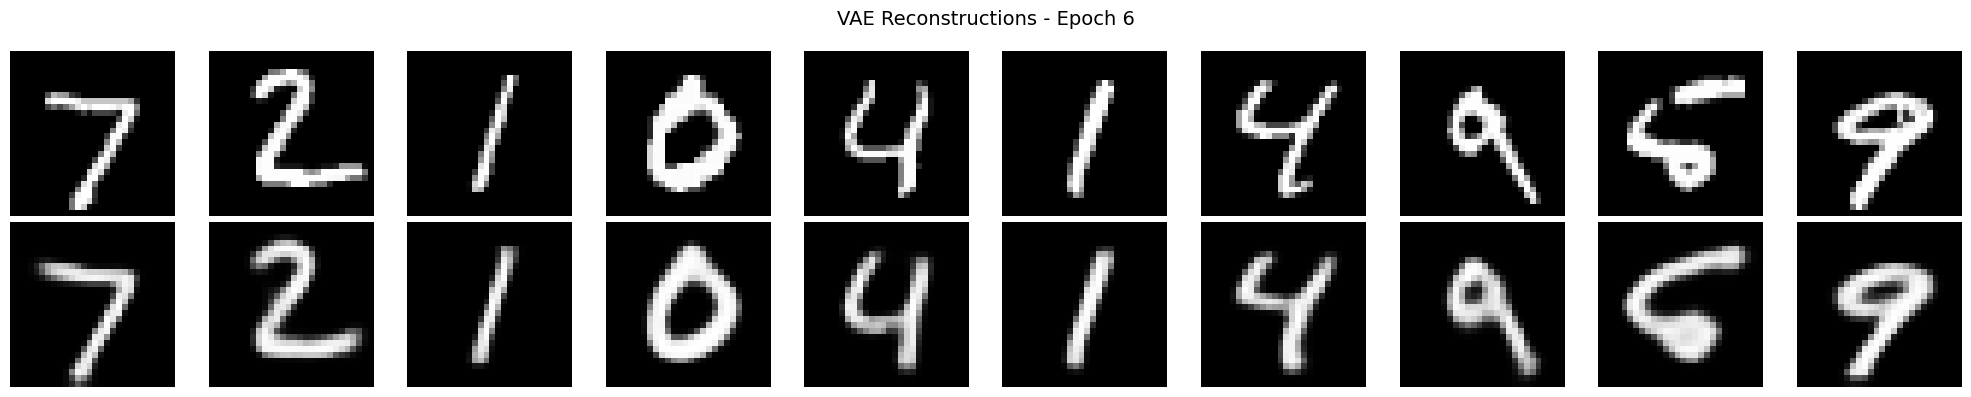

VAE Epoch [7/10], Loss: 109.8683, BCE: 85.0198, KLD: 24.8485


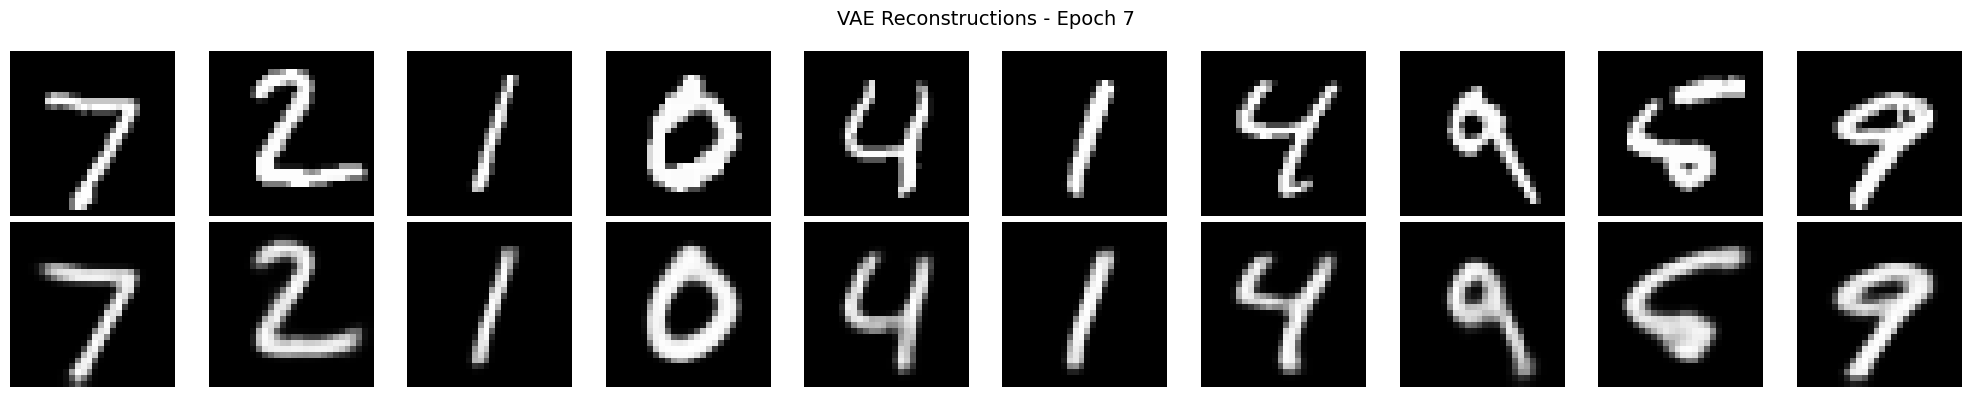

VAE Epoch [8/10], Loss: 109.1001, BCE: 84.2920, KLD: 24.8081


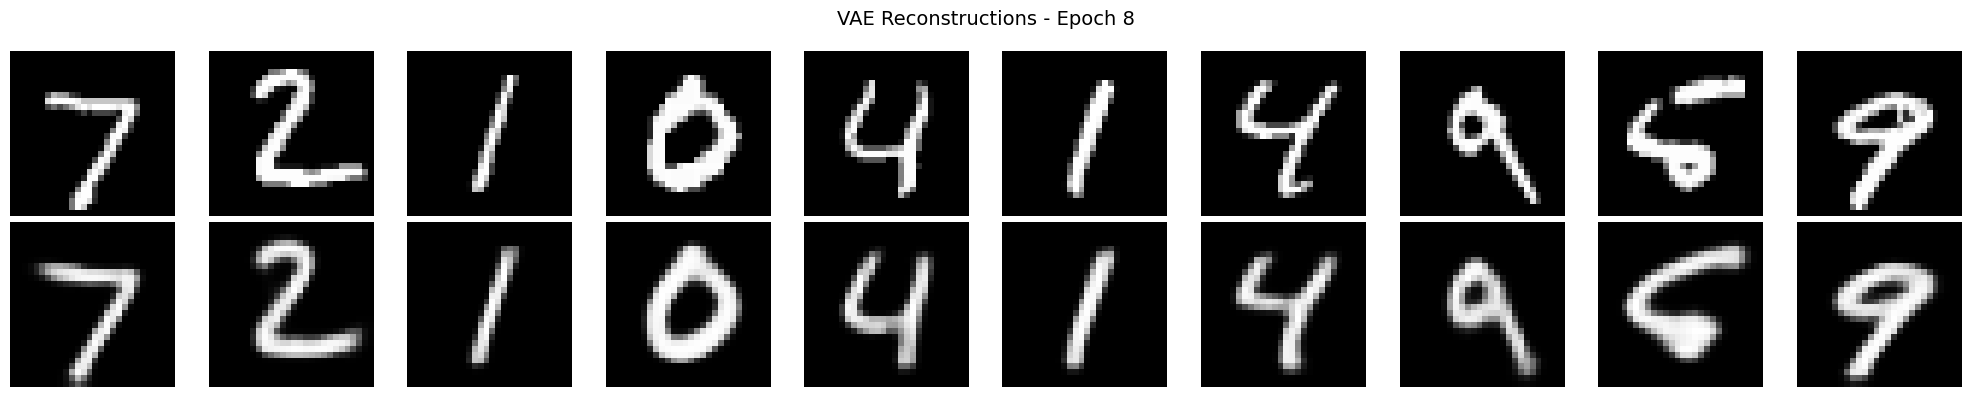

VAE Epoch [9/10], Loss: 108.6111, BCE: 83.7559, KLD: 24.8553


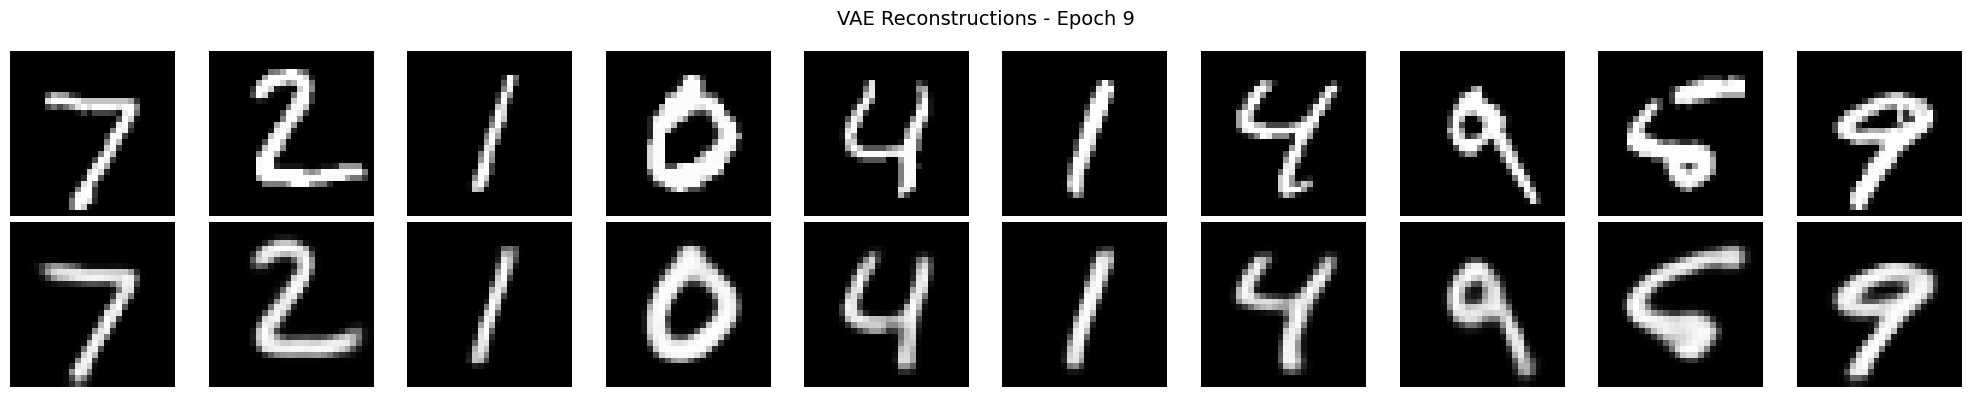

VAE Epoch [10/10], Loss: 108.1237, BCE: 83.2992, KLD: 24.8245


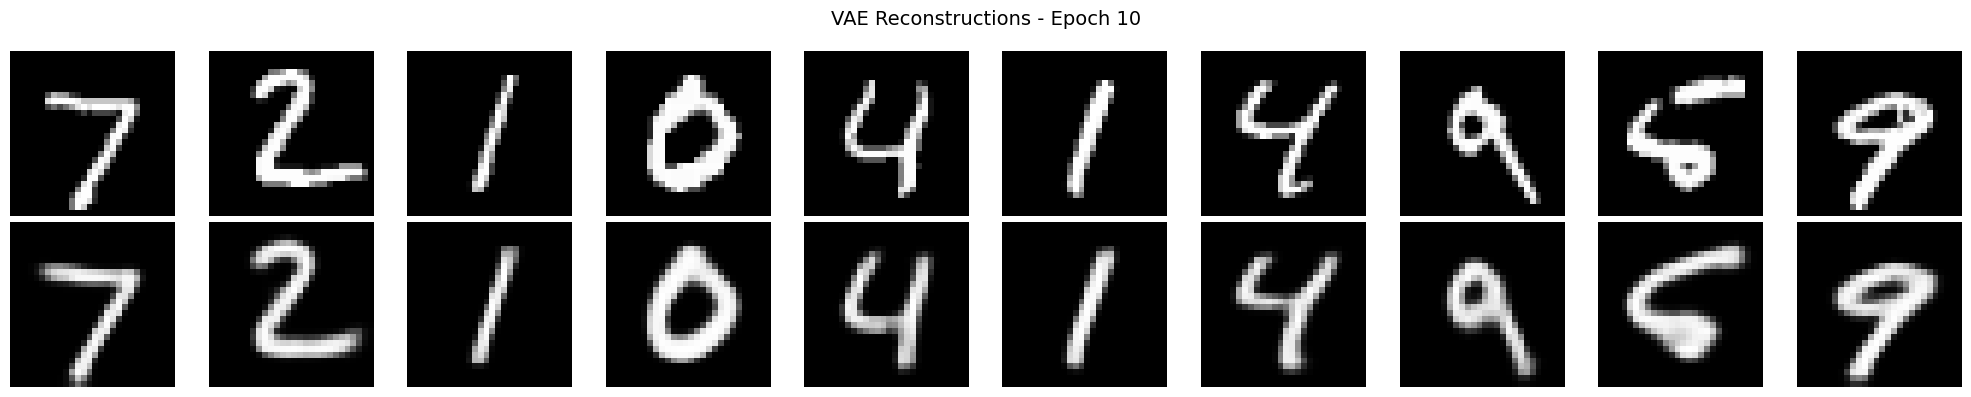

In [ ]:
import matplotlib.pyplot as plt
# Train the VAE
vae = CNNVAE(latent_dim=32).to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# Training loop
num_vae_epochs = 10
beta = 1.0  # Beta parameter for beta-VAE (1.0 = standard VAE)

print("Training VAE...")
for epoch in range(num_vae_epochs):
    vae.train()
    total_loss = 0
    total_bce = 0
    total_kld = 0

    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)

        # Forward pass
        recon_images, mu, logvar = vae(images)

        # Calculate loss
        loss, bce, kld = vae_loss_function(recon_images, images, mu, logvar, beta)

        # Backward pass
        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()

        total_loss += loss.item()
        total_bce += bce.item()
        total_kld += kld.item()

    avg_loss = total_loss / len(train_loader.dataset)
    avg_bce = total_bce / len(train_loader.dataset)
    avg_kld = total_kld / len(train_loader.dataset)

    print(f'VAE Epoch [{epoch+1}/{num_vae_epochs}], Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}')

    # Visualize reconstructions every few epochs
    if (epoch + 1) % 1 == 0 or epoch == 0:
        vae.eval()
        with torch.no_grad():
            test_images, _ = next(iter(test_loader))
            test_images = test_images.to(device)
            recon_images, _, _ = vae(test_images)

            # Plot original vs reconstructed
            fig, axes = plt.subplots(2, 10, figsize=(20, 4))
            for i in range(10):
                # Original
                axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
                axes[0, i].axis('off')
                if i == 0:
                    axes[0, i].set_ylabel('Original', fontsize=12)

                # Reconstructed
                axes[1, i].imshow(recon_images[i].cpu().squeeze(), cmap='gray')
                axes[1, i].axis('off')
                if i == 0:
                    axes[1, i].set_ylabel('Reconstructed', fontsize=12)

            plt.suptitle(f'VAE Reconstructions - Epoch {epoch+1}', fontsize=14)
            plt.tight_layout()
            plt.show()

Generating new samples from VAE...


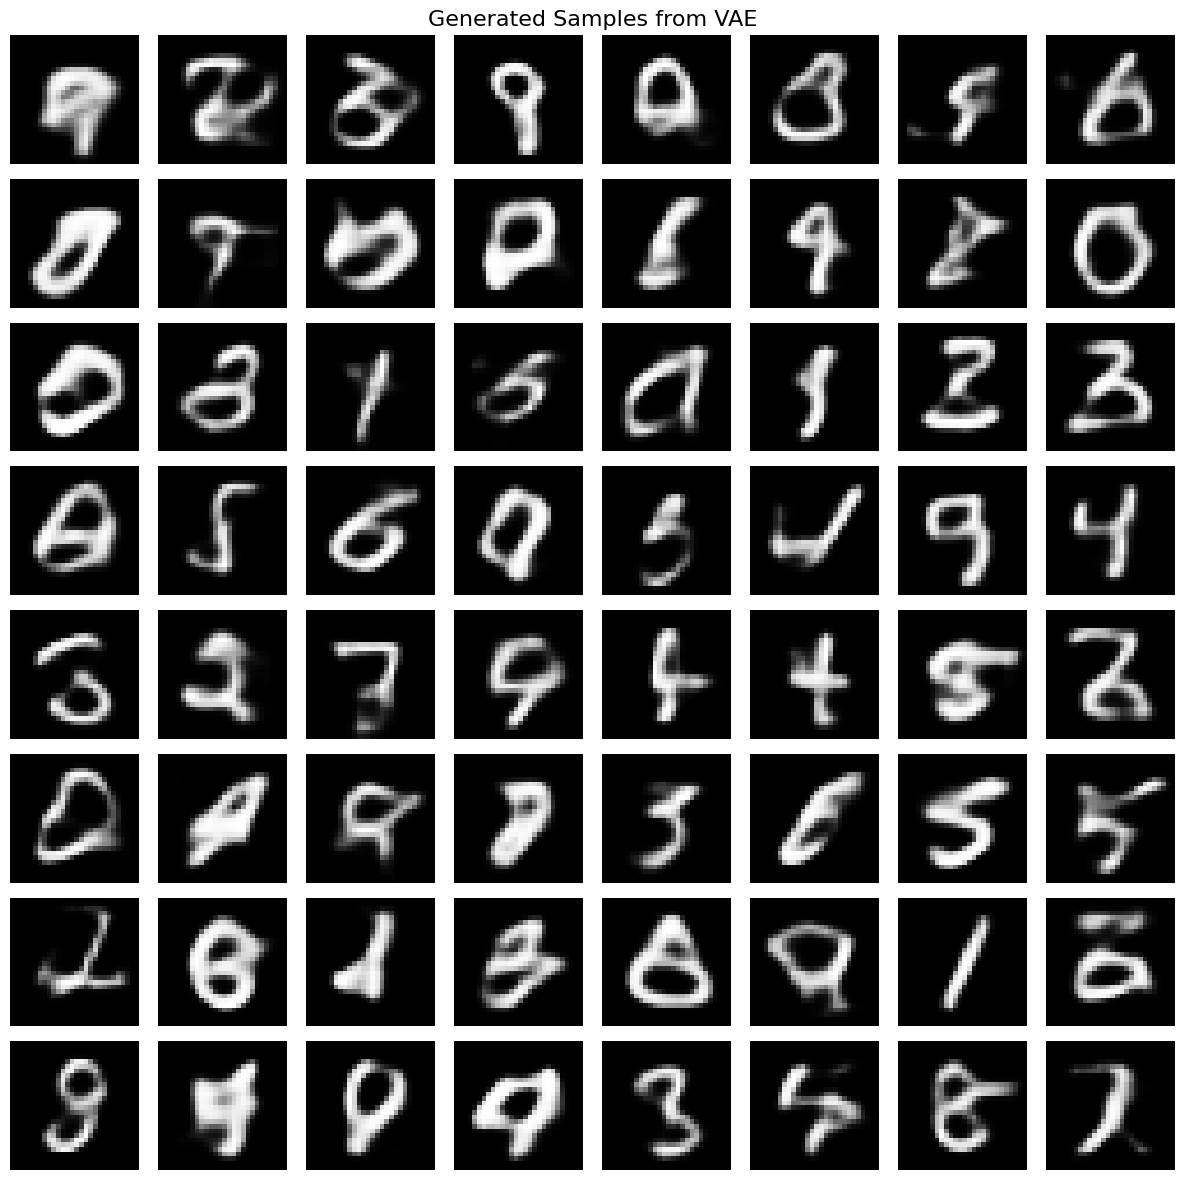

In [ ]:
from sklearn.manifold import TSNE
# Generate new samples from the VAE
print("Generating new samples from VAE...")
vae.eval()
with torch.no_grad():
    # Sample from standard normal distribution
    z = torch.randn(64, vae.latent_dim).to(device)
    generated_images = vae.decode(z)

    # Plot generated samples
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    for i in range(8):
        for j in range(8):
            idx = i * 8 + j
            axes[i, j].imshow(generated_images[idx].cpu().squeeze(), cmap='gray')
            axes[i, j].axis('off')

    plt.suptitle('Generated Samples from VAE', fontsize=16)
    plt.tight_layout()
    plt.show()



Latent space interpolation...
Interpolating between digit 3 and digit 1


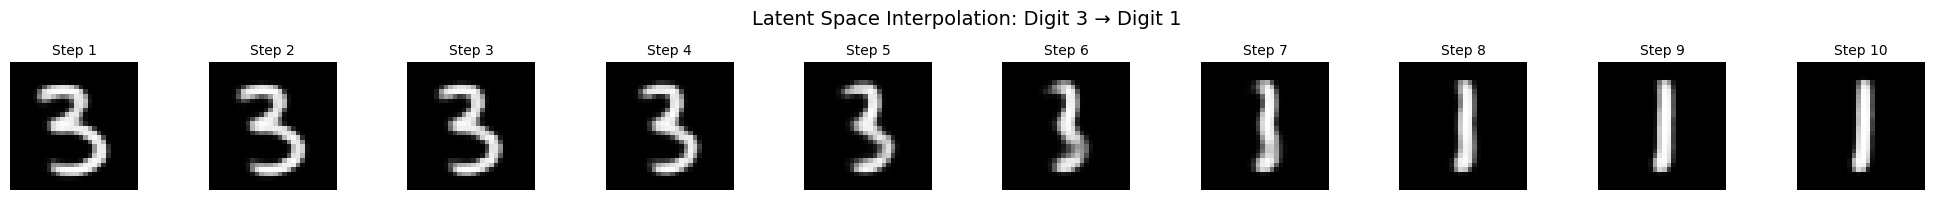

In [ ]:
import random
# Compare latent space interpolation
print("Latent space interpolation...")
vae.eval()
with torch.no_grad():
    # Get random batch of test images
    test_images, test_labels = next(iter(test_loader))
    test_images = test_images.to(device)

    # Randomly select two different digits
    available_indices = list(range(len(test_labels)))
    idx1 = random.choice(available_indices)

    # Find a different digit
    different_digits = [i for i in available_indices if test_labels[i] != test_labels[idx1]]
    if different_digits:
        idx2 = random.choice(different_digits)
    else:
        # Fallback if somehow all digits are the same (very unlikely)
        idx2 = (idx1 + 1) % len(test_labels)

    print(f"Interpolating between digit {test_labels[idx1].item()} and digit {test_labels[idx2].item()}")

    # Encode the two images
    mu1, _ = vae.encode(test_images[idx1:idx1+1])
    mu2, _ = vae.encode(test_images[idx2:idx2+1])

    # Interpolate between the two latent vectors
    n_steps = 10
    interpolated_images = []

    for i in range(n_steps):
        alpha = i / (n_steps - 1)
        z_interp = (1 - alpha) * mu1 + alpha * mu2
        img_interp = vae.decode(z_interp)
        interpolated_images.append(img_interp)

    # Plot interpolation
    fig, axes = plt.subplots(1, n_steps, figsize=(20, 2))
    for i in range(n_steps):
        axes[i].imshow(interpolated_images[i].cpu().squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Step {i+1}', fontsize=10)

    plt.suptitle(f'Latent Space Interpolation: Digit {test_labels[idx1]} → Digit {test_labels[idx2]}', fontsize=14)
    plt.tight_layout()
    plt.show()

Creating 2D manifold of digits...
Using latent dimensions 24 and 19 for manifold


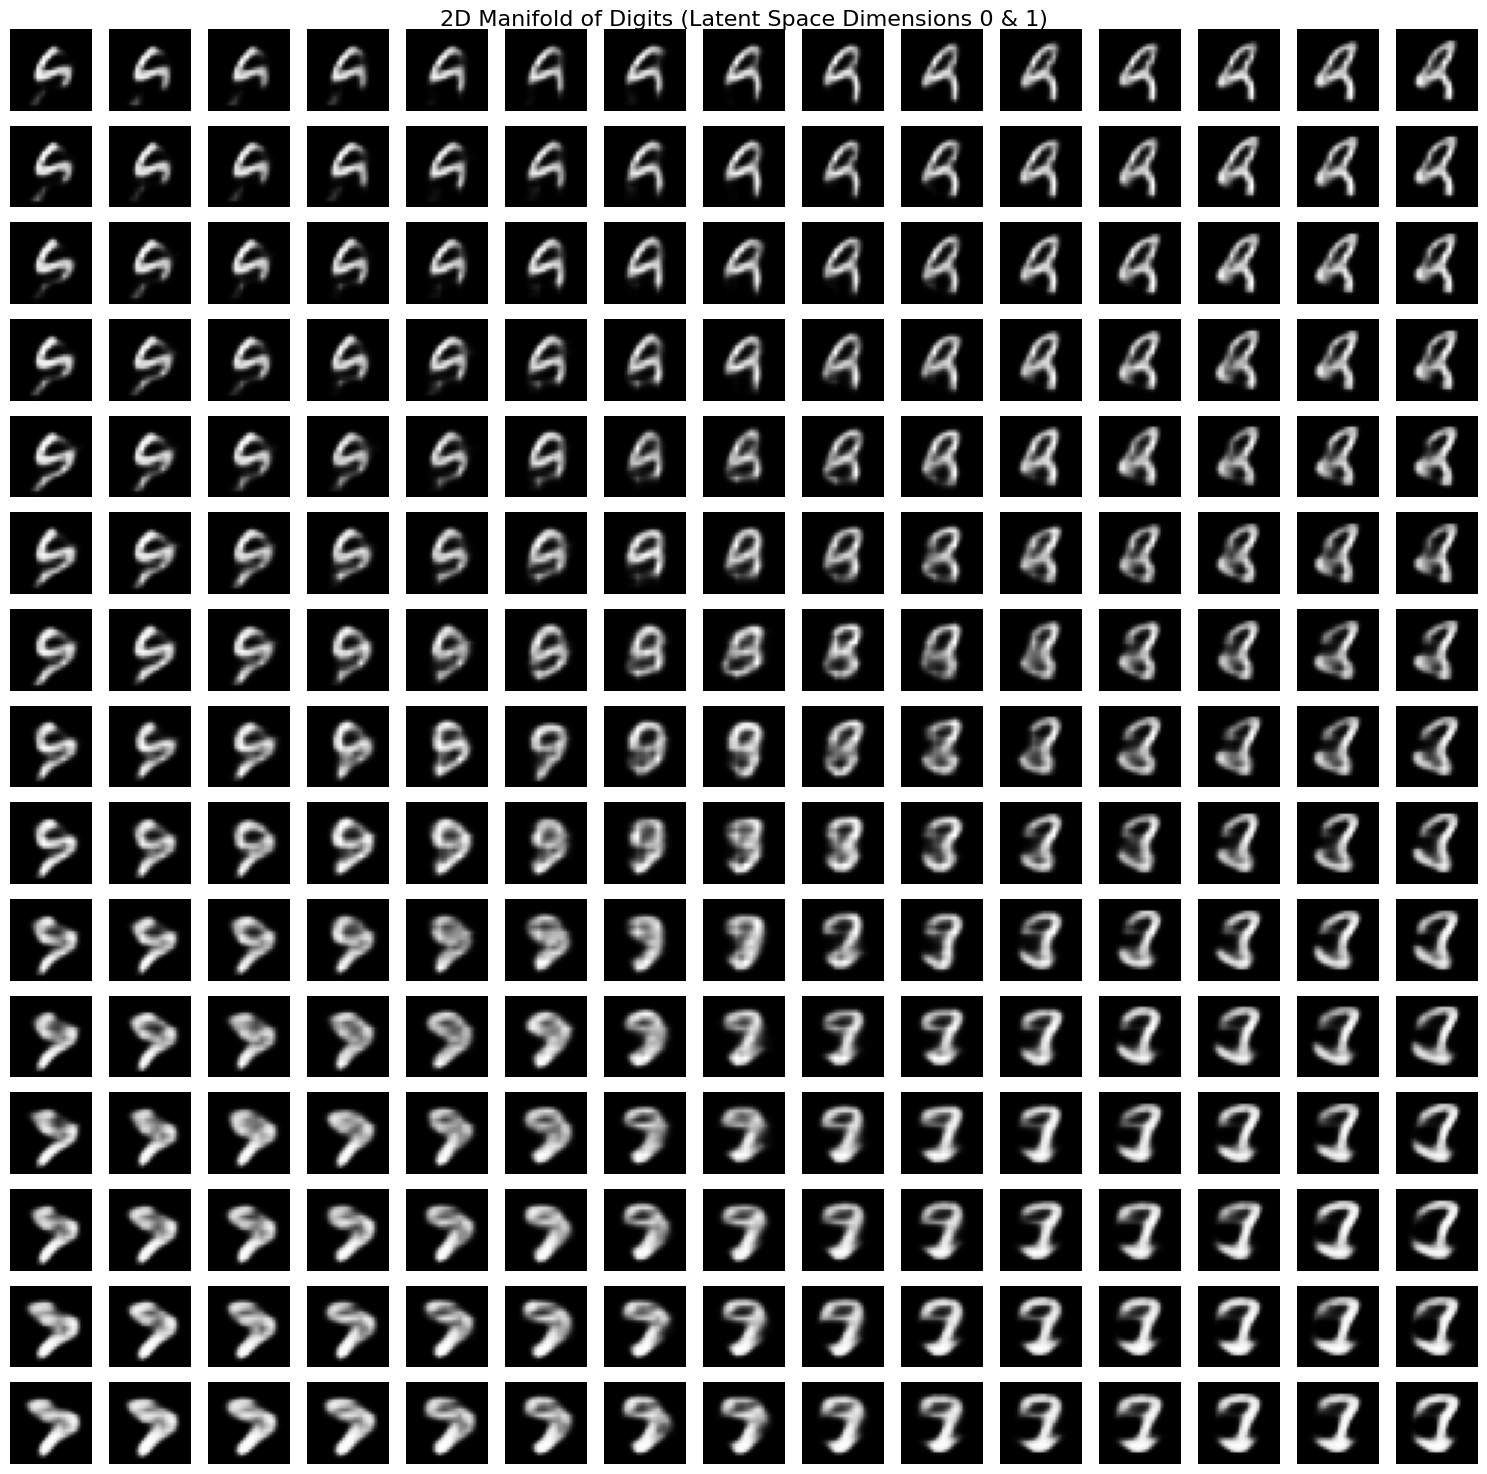

In [ ]:
# Create a 2D manifold visualization of digits
print("Creating 2D manifold of digits...")

def plot_digit_manifold(vae, n_grid=15, figsize=(15, 15)):
    """
    Plot a 2D manifold of digits by sampling from a grid in latent space
    """
    vae.eval()

    # Create a grid of points in 2D latent space
    # We'll use the first 2 dimensions of the latent space
    grid_x = np.linspace(-3, 3, n_grid)
    grid_y = np.linspace(-3, 3, n_grid)

    fig, axes = plt.subplots(n_grid, n_grid, figsize=figsize)

    # Randomly select which 2 dimensions to use for the manifold
    dim1 = np.random.randint(0, vae.latent_dim)
    dim2 = np.random.randint(0, vae.latent_dim)
    while dim2 == dim1:
        dim2 = np.random.randint(0, vae.latent_dim)

    print(f"Using latent dimensions {dim1} and {dim2} for manifold")

    with torch.no_grad():
        for i, y in enumerate(grid_y):
            for j, x in enumerate(grid_x):
                # Create latent vector with small random noise in other dimensions
                z = torch.randn(1, vae.latent_dim).to(device) * 0.1  # Small noise
                z[0, dim1] = x
                z[0, dim2] = y

                # Decode the latent vector
                decoded_img = vae.decode(z)

                # Plot the decoded image
                axes[i, j].imshow(decoded_img.cpu().squeeze(), cmap='gray')
                axes[i, j].axis('off')

    plt.suptitle('2D Manifold of Digits (Latent Space Dimensions 0 & 1)', fontsize=16)
    plt.tight_layout()
    plt.show()

# Import numpy if not already imported
import numpy as np

# Create the manifold visualization
plot_digit_manifold(vae, n_grid=15)